In [70]:
import os

import nltk
import numpy as np
import pandas as pd
import pysentiment2 as ps
import spacy
from dotenv import find_dotenv, load_dotenv
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from rich import print
from textblob import TextBlob
from transformers import BertForSequenceClassification, BertTokenizer
from finvader import finvader
from collections import Counter
import re
from nltk import sent_tokenize
import seaborn as sns
import matplotlib.pyplot as plt




%load_ext rich

load_dotenv(find_dotenv())

The rich extension is already loaded. To reload it, use:
  %reload_ext rich


False

In [2]:
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /Users/yyy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/yyy/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### Load documents

In [3]:
documents_list = os.listdir("./extracted/")

docs = {
    doc.split("_")[0]: open(f"./extracted/{doc}", "r").read()
    for doc in documents_list
    if doc.endswith(".txt")
}


### Preprocess documents

In [4]:
print(docs['AAPL'])

Item 7. Management&#8217;s Discussion and Analysis of Financial Condition and Results of Operations 

The following discussion should be read in conjunction with the consolidated financial statements and accompanying 
notes included in Part II, Item 8 of this Form 10-K. This section of this Form 10-K generally discusses 2020 and 
2019 items and year-to-year comparisons between 2020 and 2019. Discussions of 2018 items and year-to-year 
comparisons between 2019 and 2018 that are not included in this Form 10-K can be found in &#8220;Management&#8217;s
Discussion and Analysis of Financial Condition and Results of Operations&#8221; in Part II, Item 7 of the 
Company&#8217;s Annual Report on Form 10-K for the fiscal year ended September 28, 2019. 

Fiscal Year Highlights 

COVID-19 Update 

COVID-19 has spread rapidly throughout the world, prompting governments and businesses to take unprecedented 
measures in response. Such measures have included restrictions on travel and business operations, temporary 
closures of businesses, and quarantines and shelter-in-place orders. The COVID-19 pandemic has significantly 
curtailed global economic activity and caused significant volatility and disruption in global financial markets. 
The COVID-19 pandemic and the measures taken by many countries in response have adversely affected and could in the
future materially adversely impact the Company&#8217;s business, results of operations, financial condition and 
stock price. 

During 2020, aspects of the Company&#8217;s business were adversely affected by the COVID-19 pandemic, with many of
the Company&#8217;s retail stores, as well as channel partner points of sale, temporarily closed at various times, 
and the vast majority of the Company&#8217;s employees working remotely. The Company has reopened some of its 
offices and the majority of its retail stores, subject to operating restrictions to protect public health and the 
health and safety of employees and customers, and it continues to work on safely re-opening the remainder of its 
offices and retail stores, subject to local rules and regulations. 

The full extent of the future impact of the COVID-19 pandemic on the Company&#8217;s operational and financial 
performance is currently uncertain and will depend on many factors outside the Company&#8217;s control, including, 
without limitation, the timing, extent, trajectory and duration of the pandemic, the development and availability 
of effective treatments and vaccines, the imposition of protective public safety measures, and the impact of the 
pandemic on the global economy and demand for consumer products. Refer to Part I, Item 1A of this Form 10-K under 
the heading &#8220;Risk Factors,&#8221; for more information. 

The Company believes its existing balances of cash, cash equivalents and marketable securities, along with 
commercial paper and other short-term liquidity arrangements, will be sufficient to satisfy its working capital 
needs, capital asset purchases, dividends, share repurchases, debt repayments and other liquidity requirements 
associated with its existing operations. 

Fiscal 2020 Highlights 

Total net sales increased 6% or $14.3 billion during 2020 compared to 2019, primarily driven by higher net sales of
Services and Wearables, Home and Accessories. The weakness in foreign currencies had an unfavorable impact on net 
sales during 2020. 

In April 2020, the Company announced an increase to its current share repurchase program authorization from $175 
billion to $225 billion and raised its quarterly dividend from $0.1925 to $0.205 per share beginning in May 2020. 
During 2020, the Company repurchased $72.5 billion of its common stock and paid dividends and dividend equivalents 
of $14.1 billion. 

On August 28, 2020, the Company effected a four-for-one stock split to shareholders of record as of August 24, 
2020. All share, RSU and per share or per RSU information has been retroactively adjusted to reflect the stock

## Preprocessing

In [5]:
def clean_text(text):
    text = text.replace('\n', ' ')
    text = text.replace('\r', ' ')
    text = text.replace('&#',' ')
    text = text.replace("\\ ",'')
    text = text.lower()
    return text

def text_tokenize(text):
    nltk_tokens_no_stopwords = nltk.word_tokenize(text)
    return nltk_tokens_no_stopwords

def remove_stopwords(text):
    nltk_tokens_no_stopwords = [word for word in text if word not in stopwords.words('english')]
    text_no_stopwords = ' '.join(nltk_tokens_no_stopwords)
    return text_no_stopwords

def lemmatize_text(text):
    nlp = spacy.load('en_core_web_sm')
    doc = nlp(text)
    text_lemmatized = ' '.join([token.lemma_ for token in doc])
    return text_lemmatized

def preprocessing_text(text):
    text = clean_text(text)
    text = text_tokenize(text)
    text = remove_stopwords(text)
    text = lemmatize_text(text)
    return text

## Sentiment analysis

### Creating a DataFrame for Storing Results

In [55]:
result = pd.DataFrame({'Documents': list(docs.keys())})

### Loughran and McDonald Financial Sentiment Dictionaries

In [56]:
lm = ps.LM()

In [57]:
LM_res = []

for k, v in docs.items():
    
    print(
        f"[bold green]Sentiment for {k}[/bold green]\n",
        lm.get_score(lm.tokenize(preprocessing_text(v))),
    )

    scores = lm.get_score(lm.tokenize(preprocessing_text(v)))
    LM_res.append(
        {
            "LM_Positive": scores["Positive"],
            "LM_Negative": scores["Negative"],
            "LM_Polarity": scores["Polarity"],
            "LM_Subjectivity": scores["Subjectivity"]
        }
    )

result = pd.concat([result, pd.DataFrame(LM_res)], axis=1)

Sentiment for AMZN

{'Positive': 106, 'Negative': 106, 'Polarity': 0.0, 'Subjectivity': 0.05469556242138918}

Sentiment for META

{'Positive': 122, 'Negative': 162, 'Polarity': -0.14084506992660187, 'Subjectivity': 0.05650616791553797}

Sentiment for NFLX

{'Positive': 53, 'Negative': 117, 'Polarity': -0.3764705860207613, 'Subjectivity': 0.06508422662133069}

Sentiment for MSFT

{'Positive': 103, 'Negative': 107, 'Polarity': -0.0190476189569161, 'Subjectivity': 0.03952569169216531}

Sentiment for AAPL

{'Positive': 40, 'Negative': 89, 'Polarity': -0.3798449582957755, 'Subjectivity': 0.0547538200107157}

### Using `TextBlob`

In [58]:
for k, v in docs.items():
    print(
        f"[bold green]Sentiment for {k}[/bold green]\n",
        TextBlob(preprocessing_text(v)).sentiment,
    )

Sentiment for AMZN

Sentiment(polarity=0.05294354458230046, subjectivity=0.34246241840739516)

Sentiment for META

Sentiment(polarity=0.007454579853724121, subjectivity=0.4104204597358634)

Sentiment for NFLX

Sentiment(polarity=0.036569709211097375, subjectivity=0.39810747093523413)

Sentiment for MSFT

Sentiment(polarity=0.043081127206127195, subjectivity=0.32242090815167823)

Sentiment for AAPL

Sentiment(polarity=0.04445166745055878, subjectivity=0.32311038062701025)

### Using VADER

In [59]:
vader = SentimentIntensityAnalyzer()
for k, v in docs.items():
    print(
        f"[bold green]Sentiment for {k}[/bold green]\n",
        vader.polarity_scores(preprocessing_text(v)),
    )

Sentiment for AMZN

{'neg': 0.04, 'neu': 0.807, 'pos': 0.153, 'compound': 1.0}

Sentiment for META

{'neg': 0.046, 'neu': 0.804, 'pos': 0.15, 'compound': 1.0}

Sentiment for NFLX

{'neg': 0.058, 'neu': 0.786, 'pos': 0.156, 'compound': 0.9999}

Sentiment for MSFT

{'neg': 0.043, 'neu': 0.803, 'pos': 0.154, 'compound': 1.0}

Sentiment for AAPL

{'neg': 0.069, 'neu': 0.812, 'pos': 0.119, 'compound': 0.9995}

### Using pre-trained model

@misc{yang2020finbert,
    title={FinBERT: A Pretrained Language Model for Financial Communications},
    author={Yi Yang and Mark Christopher Siy UY and Allen Huang},
    year={2020},
    eprint={2006.08097},
    archivePrefix={arXiv},
    }

Only allows 512 tokens

In [10]:
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

config.json: 100%|██████████| 533/533 [00:00<00:00, 1.45MB/s]
pytorch_model.bin: 100%|██████████| 439M/439M [00:53<00:00, 8.13MB/s] 
vocab.txt: 100%|██████████| 226k/226k [00:00<00:00, 2.70MB/s]


In [11]:
def get_predictions(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True)
    outputs = finbert(**inputs)[0]

    labels = {0: "neutral", 1: "positive", 2: "negative"}

    return (text, "----", labels[np.argmax(outputs.detach().numpy())])


for k, v in docs.items():
    print(
        f"[bold green]Sentiment for {k}[/bold green]\n",
        get_predictions(preprocessing_text(v)[:512]),
    )

Sentiment for AMZN

(
    'item 7 . management 8217 ; discussion analysis financial condition result operation # # table_end forward - 
look statement annual report form 10 - k include forward - look statement within mean private security litigation 
reform act 1995 . statement statement historical fact , include statement regard guidance , industry prospect , 
future result operation financial position , make annual report form 10 - k forward - look . use word anticipate , 
believe , expect , future , intend , similar expression identif',
    '----',
    'neutral'
)

Sentiment for META

(
    "item 7 . management 's discussion analysis financial condition result operation read follow discussion 
financial condition result operation conjunction consolidate financial statement related note include part ii , 
item 8 , ` ` financial statement supplementary datum '' annual report form 10 - k. addition historical consolidated
financial information , follow discussion contain forward - look statement reflect plan , estimate , belief . 
actual result could differ materially discuss forward - look statement ",
    '----',
    'neutral'
)

Sentiment for NFLX

(
    "item 7 . management 8217 ; discussion analysis financial condition result operation section form 10 - k 
generally discuss 2020 2019 item year - to - year comparison 2020 2019 . discussion 2018 item year - to - year 
comparison 2019 2018 include form 10 - k find ` ` management 's discussion analysis financial condition result 
operation '' part ii , item 7 company 's annual report form 10 - k fiscal year end december 31 , 2019 . result 
operation follow represent consolidated performance highlight : # # table_s",
    '----',
    'neutral'
)

Sentiment for MSFT

(
    'item 7 . management 8217 ; discussion analysis financial condition result operation follow management 8217 ; 
discussion analysis financial condition result operation ( 8220 ; md 38 ; 8221 ; ) intend help reader understand 
result operation financial condition microsoft corporation . md 38 ; provide supplement , read conjunction , 
consolidated financial statement accompany note financial statement ( part ii , item 8 form 10 - k ) . overview 
microsoft technology company whose mission empower every person every',
    '----',
    'neutral'
)

Sentiment for AAPL

(
    'item 7 . management 8217 ; discussion analysis financial condition result operation follow discussion read 
conjunction consolidate financial statement accompany note include part ii , item 8 form 10 - k. section form 10 - 
k generally discuss 2020 2019 item year - to - year comparison 2020 2019 . discussion 2018 item year - to - year 
comparison 2019 2018 include form 10 - k find 8220 ; management 8217 ; discussion analysis financial condition 
result operation 8221 ; part ii , item 7 company 8217 ; annual rep',
    '----',
    'neutral'
)

### Using SentiBigNomics

In [60]:
SBN_res = []

for k, v in docs.items():
    pos = finvader(preprocessing_text(v), use_sentibignomics=True, indicator='pos')
    neg = finvader(preprocessing_text(v), use_sentibignomics=True, indicator='neg')
    compound = finvader(preprocessing_text(v), use_sentibignomics=True, indicator='compound')

    print(
        f"[bold green]Sentiment for {k}[/bold green]\n",
        f"pos: {pos}",
        f"neg: {neg}",
        f"compound: {compound}"
    )

    SBN_res.append(
        {
            "SBN_Positive": pos,
            "SBN_Negative": neg,
            "SBN_Compound": compound
        }
    )

result = pd.concat([result, pd.DataFrame(SBN_res)], axis=1)
result

Sentiment for AMZN
 pos: 0.372  neg: 0.052  compound: 0.9993

Sentiment for META
 pos: 0.293  neg: 0.051  compound: 0.9997

Sentiment for NFLX
 pos: 0.304  neg: 0.069  compound: 0.9704

Sentiment for MSFT
 pos: 0.274  neg: 0.05  compound: 0.9995

Sentiment for AAPL
 pos: 0.298  neg: 0.059  compound: 0.9941

,Documents,LM_Positive,LM_Negative,LM_Polarity,LM_Subjectivity,SBN_Positive,SBN_Negative,SBN_Compound
0,AMZN,106,106,0.000000,0.054696,0.372,0.052,0.9993
1,META,122,162,-0.140845,0.056506,0.293,0.051,0.9997
2,NFLX,53,117,-0.376471,0.065084,0.304,0.069,0.9704
3,MSFT,103,107,-0.019048,0.039526,0.274,0.050,0.9995
4,AAPL,40,89,-0.379845,0.054754,0.298,0.059,0.9941


### Using Henry's List

In [61]:
HL_res = []

for k, v in docs.items():
    # generating sentiment scores using henry's lexicon
    pos = finvader(preprocessing_text(v), use_henry=True, indicator='pos')
    neg = finvader(preprocessing_text(v), use_henry=True, indicator='neg')
    compound = finvader(preprocessing_text(v), use_henry=True, indicator='compound')

    print(
        f"[bold green]Sentiment for {k}[/bold green]\n",
        f"pos: {pos}",
        f"neg: {neg}",
        f"compound: {compound}"
    )

    HL_res.append(
        {
            "HL_Positive": pos,
            "HL_Negative": neg,
            "HL_Compound": compound
        }
    )

result = pd.concat([result, pd.DataFrame(HL_res)], axis=1)


Sentiment for AMZN
 pos: 0.162 neg: 0.045 compound: 1.0

Sentiment for META
 pos: 0.159 neg: 0.053 compound: 1.0

Sentiment for NFLX
 pos: 0.166 neg: 0.063 compound: 0.9999

Sentiment for MSFT
 pos: 0.163 neg: 0.053 compound: 1.0

Sentiment for AAPL
 pos: 0.137 neg: 0.077 compound: 0.9996

### Calculate Frequency of COVID-related Disclosure 

In [97]:
# list of words related to covid from paper
covid_word_list = """pandemic
epidemic
contagious_disease
infectious_disease
coronavirus
coronavirus_pandemic
covid_pandemic
covid
novel_coronavirus
novel_strain_coronavirus
covid_outbreak
resurgence_covid
health_crisis
public_health_crisis
outbreak
novel_strain
novel_coronavirus_disease
coronavirus_disease
"""

covid_word_list = covid_word_list.split("\n")

# getting lists of positive and negative words from vader
positive_words = [word for word in vader.lexicon if vader.lexicon[word] > 0]
negative_words = [word for word in vader.lexicon if vader.lexicon[word] < 0]

In [64]:
# helper function for splitting text into sentences
def get_sentences(text):
    return sent_tokenize(text)

# helper function for checking if a sentence contains any word from a list
def sentence_contains_wordlist(sentence, wordlist):
    words = re.findall(r'\b\w+\b', sentence.lower())
    return any(word in wordlist for word in words)


covid_res = []


for k, v in docs.items():

    # initializing variables
    sentences = get_sentences(preprocessing_text(v))
    total_sentence_count = len(sentences)
    contextual_positive_freq = 0
    contextual_negative_freq = 0
    covid_freq = 0

    # calculating contextual and covid-related disclosure frequencies 
    for sentence in sentences:
        if sentence_contains_wordlist(sentence, covid_word_list) and sentence_contains_wordlist(sentence, positive_words):
            contextual_positive_freq += 1
            covid_freq += 1
        elif sentence_contains_wordlist(sentence, covid_word_list) and sentence_contains_wordlist(sentence, negative_words):
            contextual_negative_freq += 1
            covid_freq += 1
        elif sentence_contains_wordlist(sentence, covid_word_list):
            covid_freq += 1

    # calculating covid-related frequency percentage
    covid_percentage = (covid_freq / total_sentence_count) if total_sentence_count > 0 else 0

    # print(
    #     f"[bold green]Document: {k}[/bold green]\n"
    #     f"Contextual positive frequency: {contextual_positive_freq}\n"
    #     f"Contextual negative frequency: {contextual_negative_freq}\n"
    #     f"COVID-related frequency: {covid_freq}\n"
    #     f"COVID-related frequency percentage: {covid_percentage:.2f}%\n"
    # )

    covid_res.append({
        'COVID_Related_Frequency': covid_freq,
        'COVID_Related_Frequency_Percentage': covid_percentage,
        'COVID_Contextual_Positive_Frequency': contextual_positive_freq,
        'Contextual_Negative_Frequency': contextual_negative_freq
    })

result = pd.concat([result, pd.DataFrame(covid_res)], axis=1)
result

,Documents,LM_Positive,LM_Negative,LM_Polarity,LM_Subjectivity,SBN_Positive,SBN_Negative,SBN_Compound,HL_Positive,HL_Negative,HL_Compound,COVID_Related_Frequency,COVID_Related_Frequency_Percentage,COVID_Contextual_Positive_Frequency,Contextual_Negative_Frequency
0,AMZN,106,106,0.000000,0.054696,0.372,0.052,0.9993,0.162,0.045,1.0000,20,0.082305,9,2
1,META,122,162,-0.140845,0.056506,0.293,0.051,0.9997,0.159,0.053,1.0000,15,0.043478,14,1
2,NFLX,53,117,-0.376471,0.065084,0.304,0.069,0.9704,0.166,0.063,0.9999,7,0.043478,4,2
3,MSFT,103,107,-0.019048,0.039526,0.274,0.050,0.9995,0.163,0.053,1.0000,5,0.013123,3,1
4,AAPL,40,89,-0.379845,0.054754,0.298,0.059,0.9941,0.137,0.077,0.9996,5,0.031847,4,1


## Comparing Results

In [66]:
result.head(5)

,Documents,LM_Positive,LM_Negative,LM_Polarity,LM_Subjectivity,SBN_Positive,SBN_Negative,SBN_Compound,HL_Positive,HL_Negative,HL_Compound,COVID_Related_Frequency,COVID_Related_Frequency_Percentage,COVID_Contextual_Positive_Frequency,Contextual_Negative_Frequency
0,AMZN,106,106,0.000000,0.054696,0.372,0.052,0.9993,0.162,0.045,1.0000,20,0.082305,9,2
1,META,122,162,-0.140845,0.056506,0.293,0.051,0.9997,0.159,0.053,1.0000,15,0.043478,14,1
2,NFLX,53,117,-0.376471,0.065084,0.304,0.069,0.9704,0.166,0.063,0.9999,7,0.043478,4,2
3,MSFT,103,107,-0.019048,0.039526,0.274,0.050,0.9995,0.163,0.053,1.0000,5,0.013123,3,1
4,AAPL,40,89,-0.379845,0.054754,0.298,0.059,0.9941,0.137,0.077,0.9996,5,0.031847,4,1


### Correlation Matrix

<Axes: >

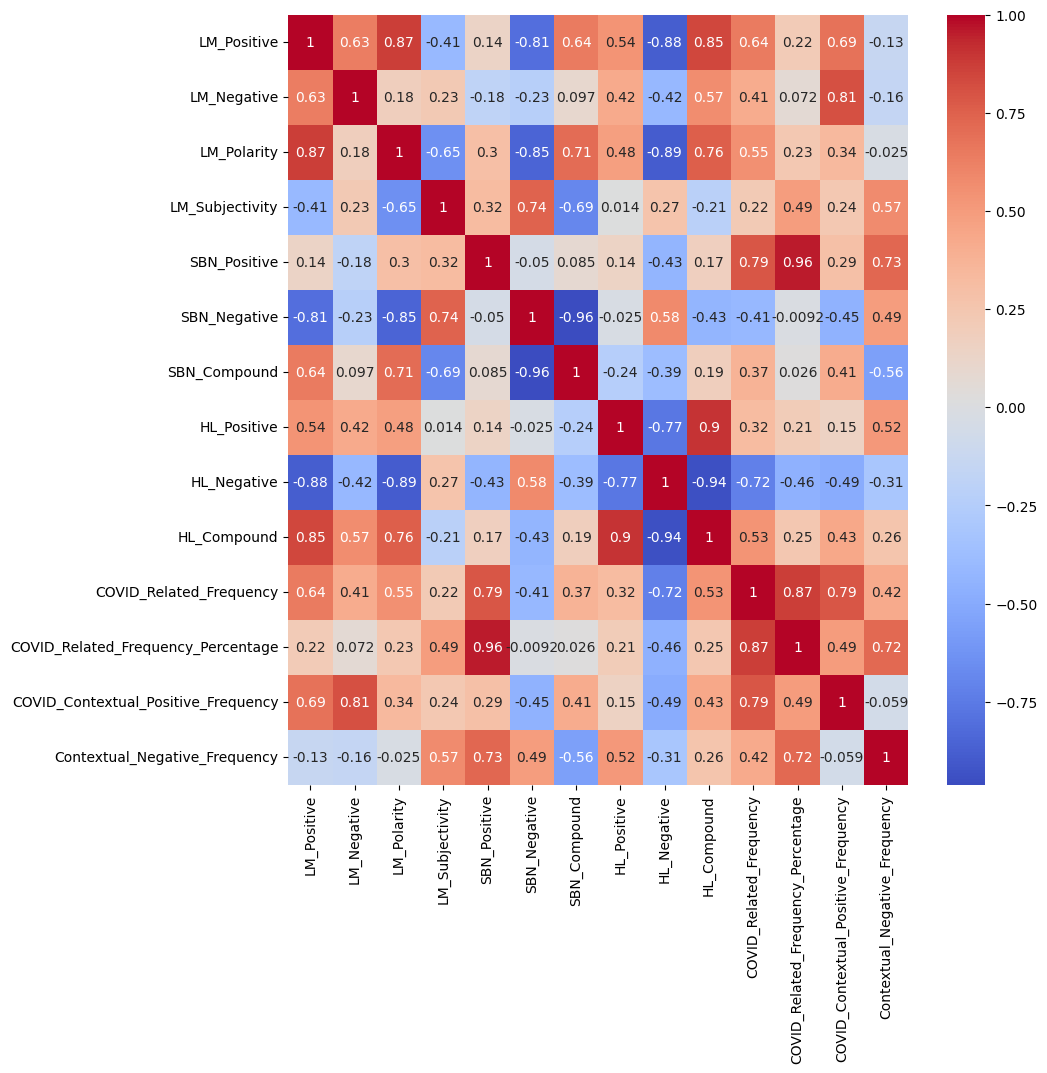

In [76]:
df = result.drop(columns=['Documents'])

correlation_matrix = df.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')


### Comparing sentiment score

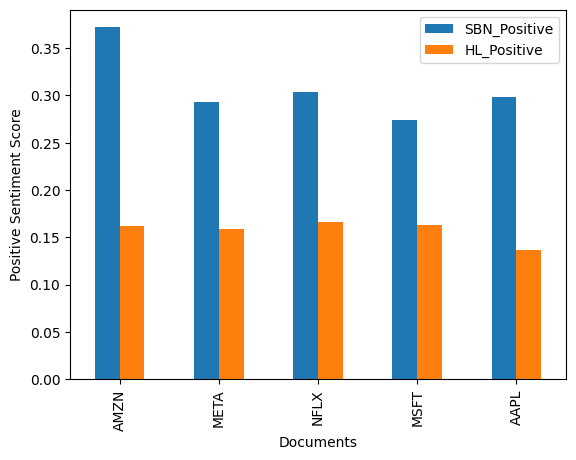

In [75]:
ax = result.plot(x='Documents', y=['SBN_Positive', 'HL_Positive'], kind='bar')
ax.set_ylabel('Positive Sentiment Score')
plt.show()

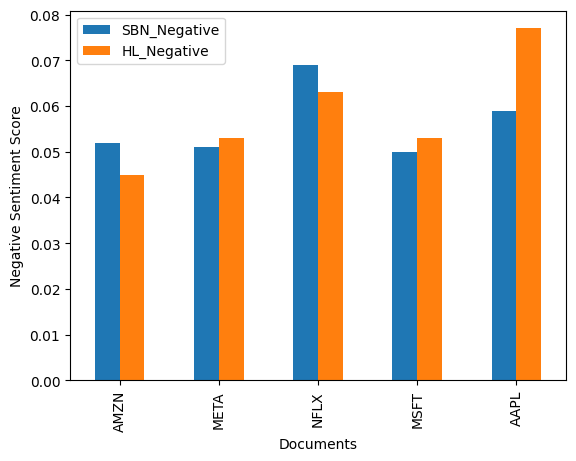

In [77]:
ax = result.plot(x='Documents', y=['SBN_Negative', 'HL_Negative'], kind='bar')
ax.set_ylabel('Negative Sentiment Score')
plt.show()

## Comparing Stock Prices with Results from Sentiment Analysis

### Loading Stock Data

In [82]:
stock_df = pd.read_csv('./data/stock_prices.csv',parse_dates=['Date'])
stock_df.head()

,Date,Close,Ticker
0,2020-06-01 00:00:00-04:00,126.354378,AAPL
1,2021-06-01 00:00:00-04:00,135.013199,AAPL
2,2020-06-01 00:00:00-04:00,172.548004,AMZN
3,2021-06-01 00:00:00-04:00,172.007996,AMZN
4,2020-06-01 00:00:00-04:00,293.200012,META


### Merging Datasets

In [92]:
# Convert the 'Date' column to datetime
stock_df['Date'] = pd.to_datetime(stock_df['Date'])

# Calculate the yearly price change for each ticker
stock_df['Year'] = stock_df['Date'].dt.year
price_change_df = stock_df.pivot(index='Ticker', columns='Year', values='Close').pct_change(axis=1) * 100

# Reset index and prepare for merging with the result
price_change_df = price_change_df.reset_index()
price_change_df = price_change_df.drop(columns=2020)
price_change_df.columns = ['Ticker', 'Price_Change']

# Merge the result with the price change dataframe
merged_df = pd.merge(result, price_change_df, left_on='Documents', right_on='Ticker')
merged_df = merged_df.drop(columns='Ticker')

In [93]:
merged_df.head()

,Documents,LM_Positive,LM_Negative,LM_Polarity,LM_Subjectivity,SBN_Positive,SBN_Negative,SBN_Compound,HL_Positive,HL_Negative,HL_Compound,COVID_Related_Frequency,COVID_Related_Frequency_Percentage,COVID_Contextual_Positive_Frequency,Contextual_Negative_Frequency,Price_Change
0,AMZN,106,106,0.000000,0.054696,0.372,0.052,0.9993,0.162,0.045,1.0000,20,0.082305,9,2,-0.312961
1,META,122,162,-0.140845,0.056506,0.293,0.051,0.9997,0.159,0.053,1.0000,15,0.043478,14,1,18.591397
2,NFLX,53,117,-0.376471,0.065084,0.304,0.069,0.9704,0.166,0.063,0.9999,7,0.043478,4,2,-0.254924
3,MSFT,103,107,-0.019048,0.039526,0.274,0.050,0.9995,0.163,0.053,1.0000,5,0.013123,3,1,21.280069
4,AAPL,40,89,-0.379845,0.054754,0.298,0.059,0.9941,0.137,0.077,0.9996,5,0.031847,4,1,6.852807


### SentiBigNomics vs. Stock Price Change

Price_Change  LM_Polarity  LM_Subjectivity  SBN_Compound  \
Price_Change         1.000000     0.384220        -0.700765      0.565711   
LM_Polarity          0.384220     1.000000        -0.646740      0.708569   
LM_Subjectivity     -0.700765    -0.646740         1.000000     -0.692503   
SBN_Compound         0.565711     0.708569        -0.692503      1.000000   
HL_Compound          0.267786     0.760373        -0.211998      0.185146   

                 HL_Compound  
Price_Change        0.267786  
LM_Polarity         0.760373  
LM_Subjectivity    -0.211998  
SBN_Compound        0.185146  
HL_Compound         1.000000

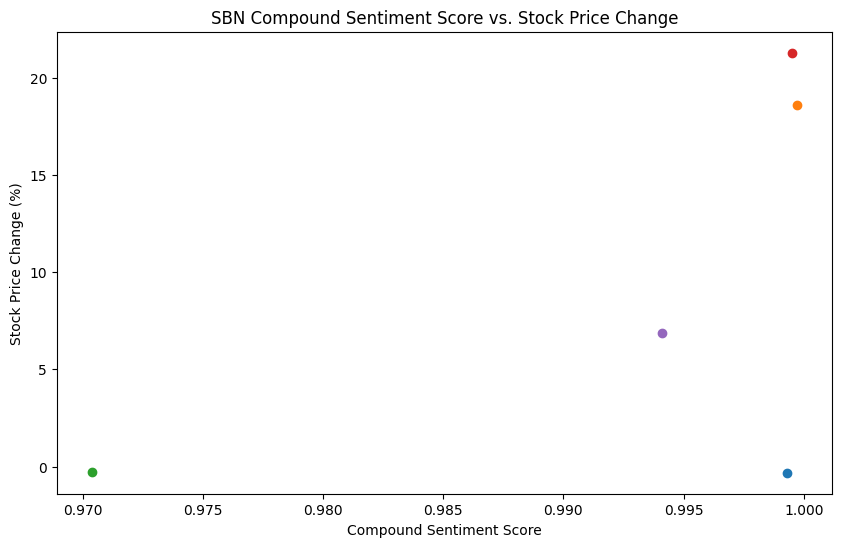

In [95]:
# Correlation analysis
correlation_matrix = merged_df[['Price_Change', 'LM_Polarity', 'LM_Subjectivity', 'SBN_Compound', 'HL_Compound']].corr()
print(correlation_matrix)

plt.figure(figsize=(10, 6))
for i, row in merged_df.iterrows():
    plt.scatter(row['SBN_Compound'], row['Price_Change'], label=row['Documents'])

plt.xlabel('Compound Sentiment Score')
plt.ylabel('Stock Price Change (%)')
plt.title('SBN Compound Sentiment Score vs. Stock Price Change')
# plt.legend()
plt.show()
